In [1]:

import numpy
import pandas
from matplotlib import pyplot as plt


In [2]:

emb = pandas.read_parquet('embedding.parquet').set_index('time')
emb.shape


(7322, 1024)

In [35]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = emb
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)
X_pca.shape

(7322, 1024)

(0.0, 128.0)

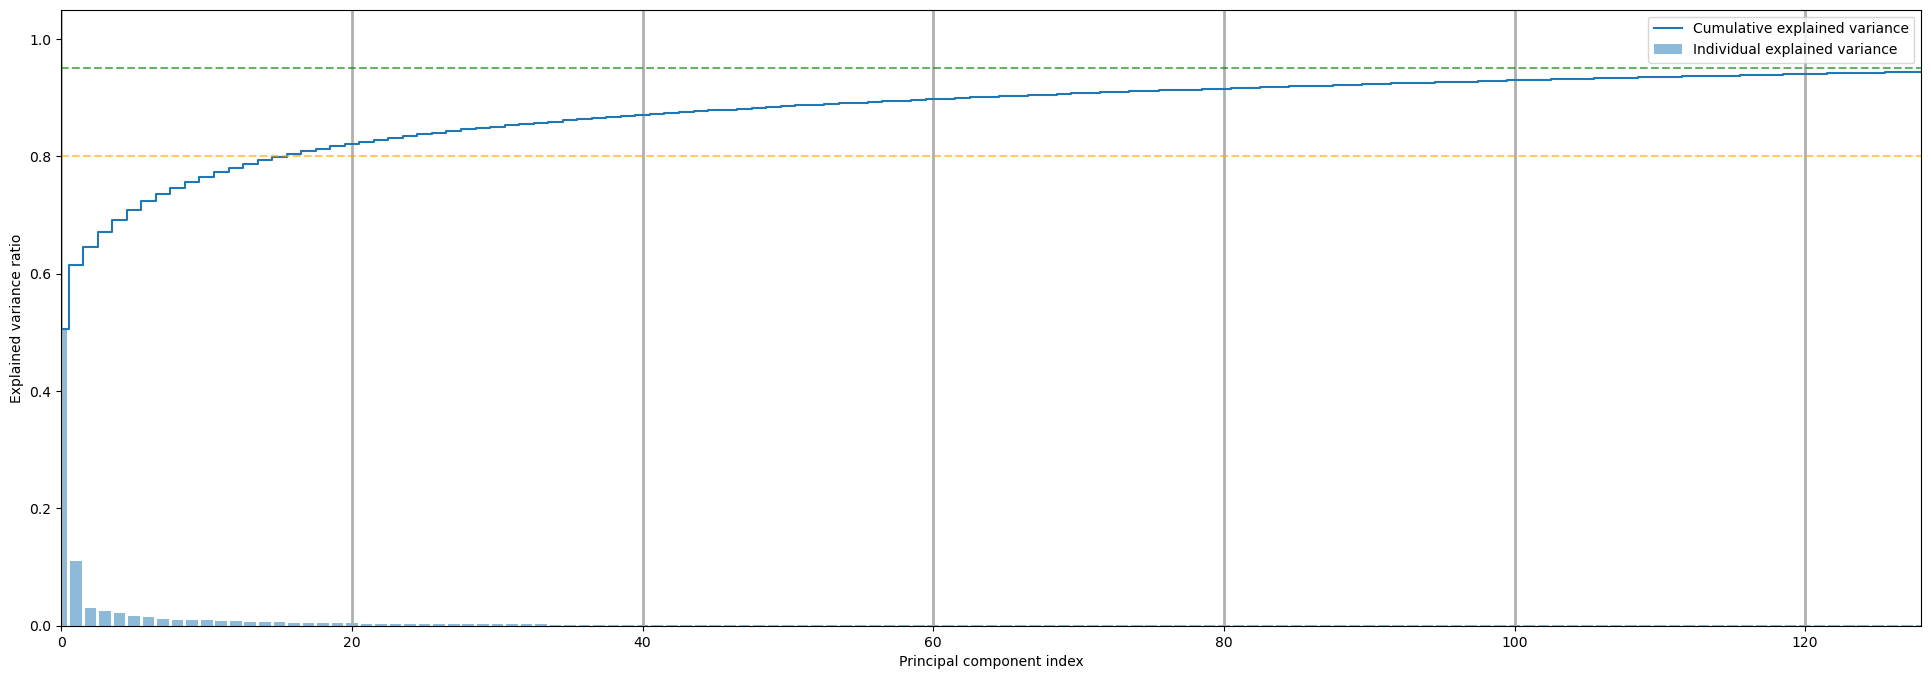

In [36]:
def plot_pca_variance(ax, pca):

    exp_var_pca = pca.explained_variance_ratio_

    cum_sum_eigenvalues = numpy.cumsum(exp_var_pca)
    
    ax.bar(range(0,len(exp_var_pca)), exp_var_pca,
           alpha=0.5,
           align='center',
           label='Individual explained variance')
    ax.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='mid',
            label='Cumulative explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.legend(loc='best')
    ax.axhline(0.80, ls='--', alpha=0.6, color='orange')
    ax.axhline(0.95, ls='--', alpha=0.6, color='green')
    ax.grid(True, axis='x', lw=2.0) 

fig, ax = plt.subplots(1, figsize=(24,8))
plot_pca_variance(ax, pca)
ax.set_xlim(0, 128)

In [37]:
emb_pca = pandas.DataFrame(X_pca[:, 0:16], index=emb.index)
emb_pca.shape

(7322, 16)

In [38]:

# Try to segment using the embeddings
# TODO: perform clustering. AgglomerativeClustering
#cluster = sklearn.cluster.AgglomerativeClustering()

for eps in numpy.linspace(4.0, 5.0, 3):

    from sklearn.cluster import DBSCAN
    cluster = DBSCAN(eps=eps, min_samples=5)
    
    cluster.fit(emb_pca)
    emb_cluster = pandas.Series(cluster.labels_, index=emb_pca.index)
    print(eps, '\n', emb_cluster.value_counts())

# TODO: plot number of clusters and noise with changing hyperparameters

4.0 
 -1     7135
 1      100
 8       14
 0        9
 11       8
 4        7
 5        6
 12       6
 2        5
 7        5
 13       5
 3        5
 6        5
 10       5
 9        4
 14       3
dtype: int64
4.5 
 -1     6443
 1      753
 10      15
 0        9
 2        8
 7        8
 18       7
 20       6
 5        6
 4        5
 12       5
 19       5
 15       5
 6        5
 13       5
 11       5
 9        5
 8        5
 21       4
 3        4
 17       4
 16       4
 22       3
 14       3
dtype: int64
5.0 
 -1     5318
 1     1946
 0        9
 9        5
 13       5
 10       5
 5        4
 12       4
 7        4
 11       4
 2        3
 3        3
 8        3
 4        3
 14       3
 6        3
dtype: int64


In [39]:

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=6)
    
cluster.fit(emb_pca)
agg_cluster = pandas.Series(cluster.labels_, index=emb_pca.index)
print(agg_cluster.value_counts())


2    5113
4    1701
5     357
3      62
1      45
0      44
dtype: int64


In [45]:
agg

time,0.00,0.48,0.96,1.44,1.92,2.40,2.88,3.36,3.84,4.32,...,3509.76,3510.24,3510.72,3511.20,3511.68,3512.16,3512.64,3513.12,3513.60,3514.08
0,1,1,1,1,1,1,1,1,1,1,...,2,0,0,1,1,0,3,3,3,2


pp 6


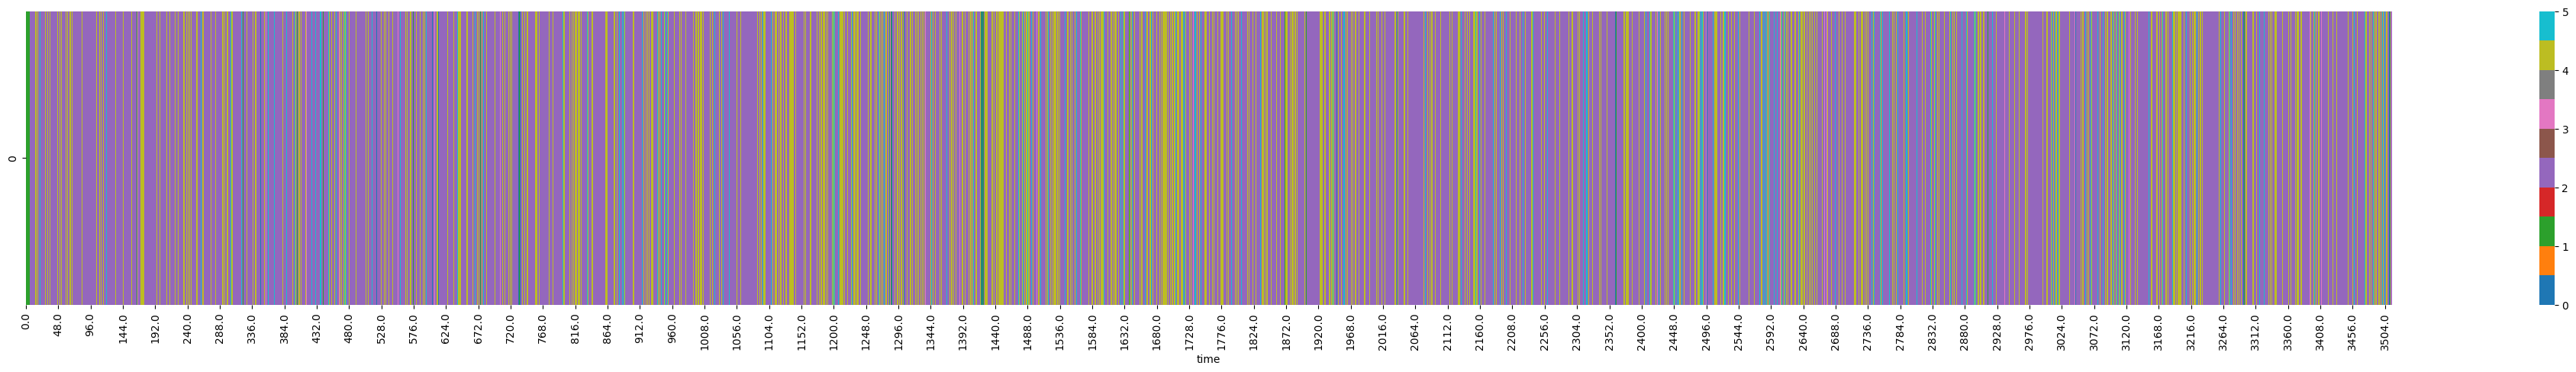

In [48]:
import seaborn

def plot_mapping(labeled, palette = 'tab10'):
    fig, ax = plt.subplots(1, figsize=(50, 5))

    print('pp', labeled.nunique())
    colors = seaborn.color_palette(palette)
    color = colors[0:labeled.nunique()]

    df = labeled.to_frame().T
    seaborn.heatmap(df, ax=ax, cmap=colors, xticklabels=100)


plot_mapping(agg_cluster)

In [76]:


def read_labels(path):
    labels = pandas.read_csv(path, sep='\t', header=None,
                            names=['start', 'end', 'annotation'],
                            dtype=dict(start=float,end=float,annotation=str))
    return labels

labels = read_labels('Conference_speakers.txt')
labels.head()


,start,end,annotation
0,4.005756,167.682063,Trym
1,169.743900,312.949668,Morten
2,313.678120,603.579771,Oystein
3,604.842930,613.474521,Alexa
4,615.579787,732.000998,Oystein


In [77]:
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Iver        3
Trym        1
Alexa       1
Name: annotation, dtype: int64

In [100]:
labels = labels[~labels.annotation.isin(['Trym', 'Alexa', 'Iver'])] # remove tiny classes
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Name: annotation, dtype: int64

In [101]:
def label_timeseries(timeseries, labels, label_column='label'):
    """
    NOTE: assumes a single label per time period
    """
    
    df = timeseries.copy()
    for start, end, label in zip(labels.start, labels.end, labels.annotation):
        df.loc[start:end, label_column] = label

    return df

emb_labeled = label_timeseries(emb, labels=labels)
emb_labeled.label.value_counts(dropna=False)

Morten     1816
Jon        1757
Oystein    1647
Audun      1317
NaN         785
Name: label, dtype: int64

In [102]:
data

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,...,e1015,e1016,e1017,e1018,e1019,e1020,e1021,e1022,e1023,label
time,,,,,,,,,,,,,,,,,,,,,
169.92,0.176054,0.171117,0.658909,0.000000,0.058137,0.000000,0.040356,0.080256,0.128111,0.318552,...,0.002660,0.000000,0.000000,0.000000,0.000000,0.026043,0.007927,0.000000,0.000000,Morten
170.40,0.356680,0.226783,0.569257,0.017390,0.098932,0.000000,0.052414,0.057486,0.155392,0.321516,...,0.070620,0.000000,0.249213,0.000000,0.000000,0.339547,0.010238,0.152880,0.000000,Morten
170.88,0.413041,0.001732,0.563033,0.000000,0.044488,0.000000,0.077984,0.000000,0.203575,0.515575,...,0.434022,0.000000,0.070310,0.000000,0.000000,0.406849,0.065501,0.000000,0.000000,Morten
171.36,0.000000,0.003521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176192,0.702394,...,0.329284,0.000000,0.003756,0.000000,0.000000,0.211879,0.098989,0.000000,0.000000,Morten
171.84,0.381880,0.000000,0.094256,0.078017,0.000000,0.000000,0.093004,0.000000,0.063076,0.497555,...,0.360877,0.000000,0.000000,0.000000,0.000000,0.201218,0.014116,0.000000,0.000000,Morten
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508.80,0.410372,0.392584,0.000000,0.000000,0.005668,0.000000,0.001985,0.031118,0.006315,0.073508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.016347,0.000000,0.000000,0.000000,Morten
3509.28,0.155249,0.049735,0.494288,0.000000,0.066838,0.000000,0.000000,0.000000,0.173394,0.004041,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.793183,0.235333,0.000000,0.000000,Morten
3509.76,0.123216,0.000000,0.389150,0.000000,0.118907,0.000000,0.000000,0.000000,0.084387,0.056254,...,0.008137,0.000000,0.000000,0.000000,0.000000,0.401145,0.000000,0.000000,0.000000,Morten


In [120]:
# prepare dataset
test_split_time = 1900.0 # after this there is a panel

data = emb_labeled.copy()
data = data.dropna(subset=['label']) # drop areas without annotations

feature_columns = data.columns[(data.columns.str.startswith('e'))]

train_data = data.loc[0:test_split_time]

test_data = data.loc[test_split_time:]


X_train = train_data[feature_columns]
y_train = train_data['label']

X_test = test_data[feature_columns]
y_test = test_data['label']

print('train')
print(y_train.value_counts())
print('test')
print(y_test.value_counts())

train
Jon        1065
Audun       995
Oystein     908
Morten      591
Name: label, dtype: int64
test
Morten     1225
Oystein     739
Jon         692
Audun       322
Name: label, dtype: int64


In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import sklearn.metrics

estimator = make_pipeline(
    StandardScaler(),
    PCA(32),
    KNeighborsClassifier(32),
    #DummyClassifier(),
)

# TODO: balance out the different speakers in training set
# TODO: see what happens with performance as we reduce training set size. Run multiple experiments per size, random samples

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'micro')
scores = cross_val_score(estimator=estimator, X=X_train, y=y_train, scoring=scorer)
estimator.fit(X_train, y_train) # re-fit entire dataset

scores

array([0.67837079, 0.69803371, 0.74157303, 0.69803371, 0.64978903])

In [122]:
scorer(estimator, X_test, y_test)

0.5983881799865681

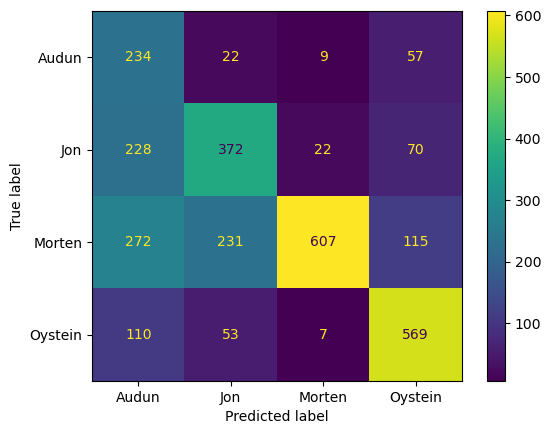

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)

In [154]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

pred = estimator.predict(X_test)
pred = pandas.Series(pred, index=test_data.index, name='label').to_frame()
pred

,label
time,
1900.32,Jon
1900.80,Jon
1901.28,Oystein
1901.76,Oystein
1902.24,Oystein
...,...
3508.80,Oystein
3509.28,Audun
3509.76,Jon


In [161]:
def predict_proba(estimator, data):
    """
    predict_proba with proper pandas.DataFrame support
    """

    X = data[feature_columns] # XXX: global
    pp = estimator.predict_proba(X)
    df = pandas.DataFrame(pp, index=data.index, columns=estimator.classes_)

    return df

pp = predict_proba(estimator, test_data)
pp

,Audun,Jon,Morten,Oystein
time,,,,
0 days 00:31:40.320000,0.18750,0.53125,0.28125,0.00000
0 days 00:31:40.800000,0.25000,0.50000,0.09375,0.15625
0 days 00:31:41.280000,0.21875,0.12500,0.00000,0.65625
0 days 00:31:41.760000,0.18750,0.21875,0.03125,0.56250
0 days 00:31:42.240000,0.18750,0.21875,0.03125,0.56250
...,...,...,...,...
0 days 00:58:28.800000,0.31250,0.15625,0.09375,0.43750
0 days 00:58:29.280000,0.31250,0.15625,0.31250,0.21875
0 days 00:58:29.760000,0.31250,0.43750,0.12500,0.12500


In [169]:
def resample(df, freq='3s', agg='median'):

    df = df.copy()
    df.index = pandas.to_timedelta(df.index, unit='s')

    r = df.resample(freq).agg(agg)
    r.index = r.index.total_seconds()

    return r

ll = resample(pp)
#ll = label_timeseries(ll, labels=labels)
#ll.label.value_counts()

In [174]:
llp = ll.values.argmax(axis=1)

ll.shape, llp.shape

((537, 4), (537,))

In [179]:
class_map_idx = dict(zip(range(0, 4), estimator.classes_))
class_map_idx


{0: 'Audun', 1: 'Jon', 2: 'Morten', 3: 'Oystein'}

In [181]:
smooth = pandas.Series(llp, index=ll.index).replace(class_map_idx)
smooth

time
1900.32    Oystein
1903.32        Jon
1906.32      Audun
1909.32     Morten
1912.32     Morten
            ...   
3496.32     Morten
3499.32     Morten
3502.32     Morten
3505.32     Morten
3508.32      Audun
Length: 537, dtype: object

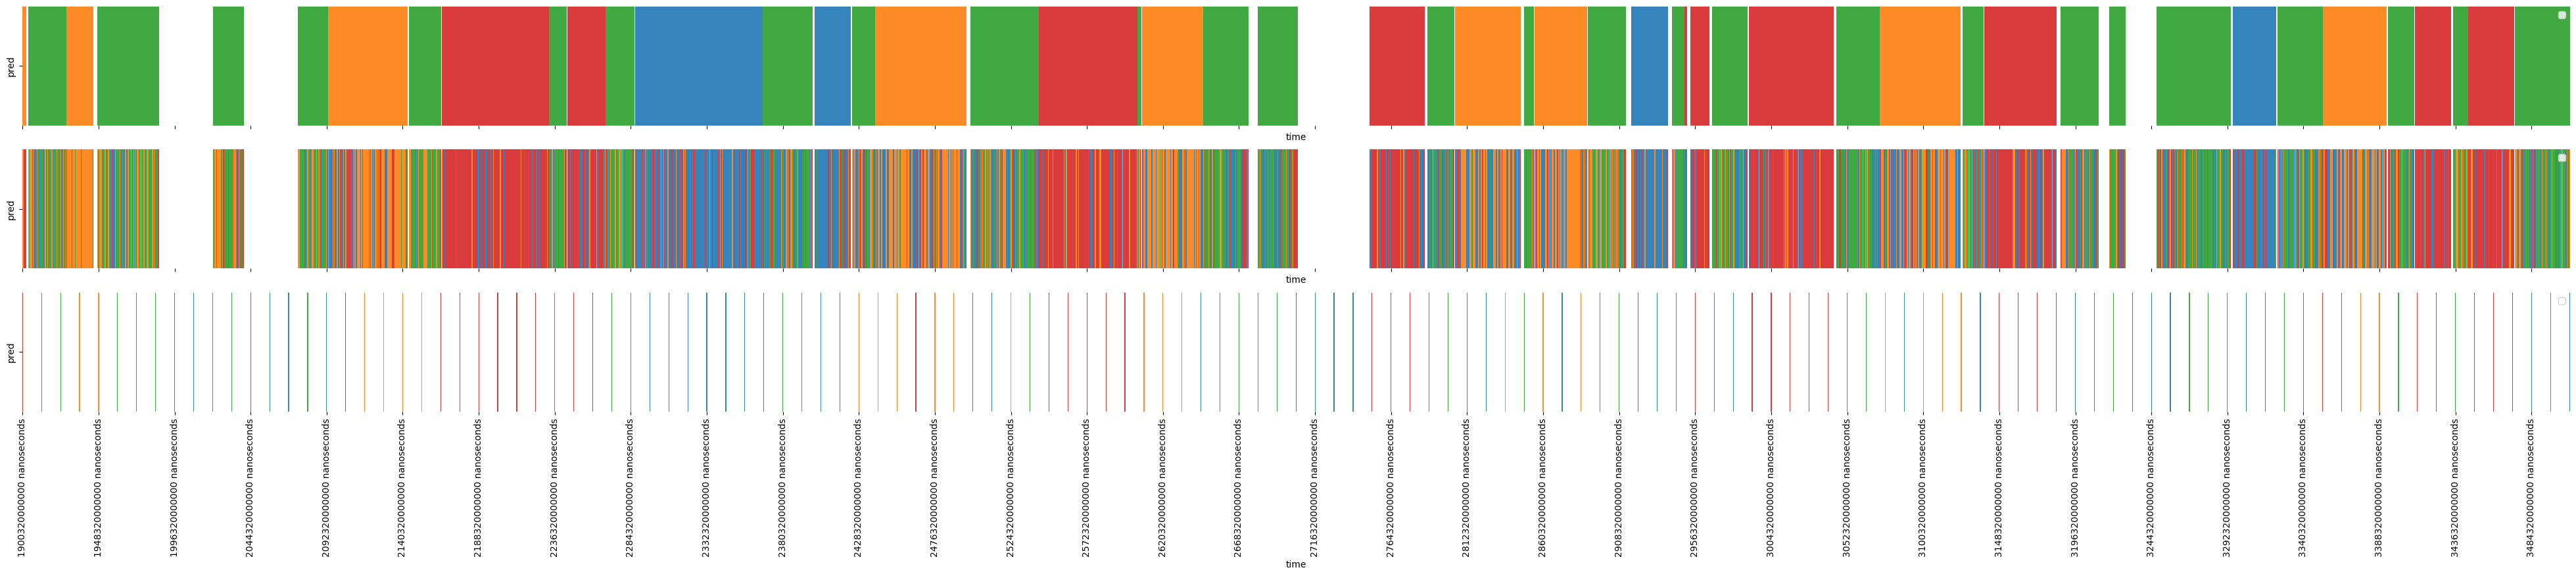

In [182]:

def plot_mapping(ax, labeled, palette = 'tab10'):
    
    colors = seaborn.color_palette(palette)
    colors = colors[0:labeled.nunique()]

    # TODO: support categorical names for labels, not just indices
    enc = LabelEncoder()
    labeled = pandas.Series(enc.fit_transform(labeled), index=labeled.index)
    
    # handle holes in the input data
    hop_duration = 0.480
    full_times = numpy.arange(labeled.index.min(), labeled.index.max(), hop_duration)
    full = pandas.DataFrame({ 'time': pandas.to_timedelta(full_times, unit='s'), 'pred': None }).set_index('time')
    df = labeled.copy()
    df.index = pandas.to_timedelta(df.index, unit='s')
    full['pred'] = df

    
    df = full.T
    seaborn.heatmap(df, ax=ax, cmap=colors, xticklabels=100, cbar=False, alpha=0.9)

    # FIXME: add a legend with labels
    labels = enc.inverse_transform(range(len(colors)))
    ax.legend(labels=labels)


fig, (ref_ax, pred_ax, smooth_ax)  = plt.subplots(3, figsize=(50, 8), sharex=True)

plot_mapping(ref_ax, test_data['label'])
plot_mapping(pred_ax, pred['label'])
plot_mapping(smooth_ax, smooth)
